    Challenge Set 1
    Topic:        Explore MTA turnstile data
    Date:         04/12/2016
    Name:         Ian London

# Challenge 1

In [1]:
import requests
import csv
import re
from collections import defaultdict, namedtuple
import dateutil.parser
import numpy as np

def strip_regex(name, pattern=r'[^\w]'):
    # remove all but alphanumberic characters and underscores
    # this is for compatibility with namedtuple
    return re.sub(pattern, '', name)

class DictReaderStrip(csv.DictReader):
    # Thanks to CivFan at http://stackoverflow.com/questions/14885908/strip-white-spaces-from-file-csv
    @property
    def fieldnames(self):
        if self._fieldnames is None:
            # Initialize self._fieldnames
            # Note: DictReader is an old-style class, so can't use super()
            csv.DictReader.fieldnames.fget(self)
            if self._fieldnames is not None:
                self._fieldnames = [strip_regex(name) for name in self._fieldnames]
        return self._fieldnames


def load_data(filename):
    data = []
    with open(filename, 'rb') as csvfile:
        reader = DictReaderStrip(csvfile)
        for row in reader:
            data.append(row)
    return data


def make_keyed_dict(data, key_fields):
    """
    Use the specified list of key_fields to generate a dict of the form:
    {('key field 1','key field 2', ...):[ [other fields here], [other fields here ], ...}
    The "other fields" in the values are all the fields not in the key fields.
    data should be in csv.DictReader form
    """
    if type(key_fields) == str:
        raise ValueError('expected a sequence, not a string')

    # make key_fields a tuple for use as a dict key
    key_fields = tuple(key_fields)

    # get headers from first row
    headers = data[0].keys()

    for key in key_fields:
        if not key in headers:
            raise ValueError("key field '%s' not in data headers" % key)

    # generate value fields - all fields that aren't in the key fields.
    value_fields = [field for field in headers if field not in key_fields]

    named_tuple_base = namedtuple('nt_base', value_fields)
    keyed_dict = defaultdict(list)
    
    for row in data:
        values_dict = {val_key:row[val_key] for val_key in value_fields}
        named_vals = named_tuple_base(**values_dict)
        key_tuple = tuple([row[k] for k in key_fields])
        keyed_dict[key_tuple].append(named_vals)

    return keyed_dict


csv_path = 'turnstile_160402.txt'
data = load_data(csv_path)
turnstile_kd = make_keyed_dict(data, ['CA','UNIT','SCP','STATION'])

print 'values look like this:\n'
turnstile_kd.items()[0][1][:3]

values look like this:



[nt_base(DIVISION='IND', LINENAME='A', EXITS='0002890032                                          ', ENTRIES='0007238654', TIME='01:00:00', DATE='03/26/2016', DESC='REGULAR'),
 nt_base(DIVISION='IND', LINENAME='A', EXITS='0002890044                                          ', ENTRIES='0007238667', TIME='05:00:00', DATE='03/26/2016', DESC='REGULAR'),
 nt_base(DIVISION='IND', LINENAME='A', EXITS='0002890069                                          ', ENTRIES='0007238807', TIME='09:00:00', DATE='03/26/2016', DESC='REGULAR')]

Use the keyed dictionary like this:

In [2]:
example_key = turnstile_kd.keys()[0]

print 'example_key:', example_key

print '\nentries:', turnstile_kd[(example_key)][0].ENTRIES

print '\nproperty values:'

for d in dir(turnstile_kd[(example_key)][0]):
    if d[0] != '_':
        if d not in ['count','index']:
            print '  ' + d

example_key: ('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD')

entries: 0007238654

property values:
  DATE
  DESC
  DIVISION
  ENTRIES
  EXITS
  LINENAME
  TIME


# Challenge 2

In [3]:
def challenge_2_fn(kd):
    """
    Turns the dict from challenge 1 into a time series, 
    so each key has a value like [(datetime1, no_entries1), ... etc]
    """
    timeseries = defaultdict(list)
    for key, list_of_named_tuples in kd.items():
        for row in list_of_named_tuples:
            dt = dateutil.parser.parse('%s %s' % (row.DATE, row.TIME))
            timeseries[key].append((dt, int(row.ENTRIES)))
    return timeseries

challenge2 = challenge_2_fn(turnstile_kd)

print example_key
print challenge2[example_key][:3]

('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD')
[(datetime.datetime(2016, 3, 26, 1, 0), 7238654), (datetime.datetime(2016, 3, 26, 5, 0), 7238667), (datetime.datetime(2016, 3, 26, 9, 0), 7238807)]


# Challenge 3

These counts are for every **4** hours (ideally)

In [4]:
def challenge_3_fn(ch2_kd):
    """
    Converts the time series dict from challenge 2 to a daily-entries time series.
    """
    ch3 = defaultdict(list)
    
    for key, values in ch2_kd.items():
        
        date_keyed_entries = defaultdict(int)
        
        for datetime, entries in values:
            # round down datetime to the 'day' resolution
            date_keyed_entries[datetime.replace(hour=0, minute=0, second=0, microsecond=0)] += entries
        
        ch3[key] = date_keyed_entries
    
    return ch3

ch3 = challenge_3_fn(challenge2)

example_day = ch3[example_key].keys()[0]

print example_key
print '...'
print ch3[example_key]
print '...'
print ch3[example_key][example_day]

('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD')
...
defaultdict(<type 'int'>, {datetime.datetime(2016, 3, 28, 0, 0): 43444021, datetime.datetime(2016, 3, 29, 0, 0): 43452920, datetime.datetime(2016, 3, 30, 0, 0): 43462336, datetime.datetime(2016, 3, 26, 0, 0): 43433706, datetime.datetime(2016, 3, 31, 0, 0): 43471695, datetime.datetime(2016, 4, 1, 0, 0): 43480624, datetime.datetime(2016, 3, 27, 0, 0): 43438036})
...
43444021


# Challenge 4

In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(csv_path)

data.head()

/home/ian/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,00:00:00,REGULAR,5595746,1893277
1,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,04:00:00,REGULAR,5595746,1893282
2,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,08:00:00,REGULAR,5595746,1893282
3,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,12:00:00,REGULAR,5595746,1893282
4,A002,R051,02-00-00,59 ST,NQR456,BMT,03/26/2016,16:00:00,REGULAR,5595746,1893282


In [6]:
turnstile_groupby = data.groupby(['C/A','UNIT','SCP','STATION','DATE'])
turnstile_sums = turnstile_groupby.sum()

turnstile_sums.head()

ENTRIES  \
C/A  UNIT SCP      STATION DATE                   
A002 R051 02-00-00 59 ST   03/26/2016  33574476   
                           03/27/2016  33574476   
                           03/28/2016  33576081   
                           03/29/2016  33583004   
                           03/30/2016  33589744   

                                       EXITS                                                                 
C/A  UNIT SCP      STATION DATE                                                                              
A002 R051 02-00-00 59 ST   03/26/2016                                           11359687                     
                           03/27/2016                                           11359692                     
                           03/28/2016                                           11361307                     
                           03/29/2016                                           11365754                     
                           03/30/2016                                           11370963

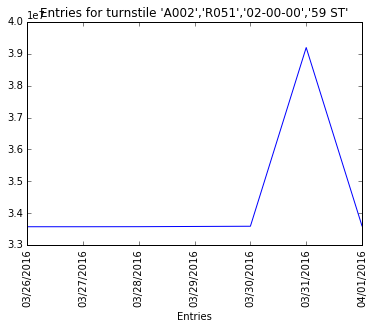

In [7]:
plot = turnstile_sums.loc['A002','R051','02-00-00','59 ST'].ENTRIES.plot(
    title="Entries for turnstile 'A002','R051','02-00-00','59 ST'", 
    rot=90)

plot.set_xlabel('Entries')
plot.plot();

# Challenge 5

In [8]:
ca_unit_sums = data.groupby(['C/A', 'UNIT', 'STATION', 'DATE']).sum()
ca_unit_sums.head()

ENTRIES  \
C/A  UNIT STATION DATE                    
A002 R051 59 ST   03/26/2016  325300976   
                  03/27/2016  325318020   
                  03/28/2016  325343252   
                  03/29/2016  325438568   
                  03/30/2016  325538031   

                              EXITS                                                                 
C/A  UNIT STATION DATE                                                                              
A002 R051 59 ST   03/26/2016                                          184249789                     
                  03/27/2016                                          184249454                     
                  03/28/2016                                          184275925                     
                  03/29/2016                                          184338034                     
                  03/30/2016                                          184403488

# Challenge 6

In [9]:
station_daily_sums = data.groupby(['STATION','DATE']).sum()
station_daily_sums.head()

ENTRIES  \
STATION DATE                     
1 AV    03/26/2016  9360477057   
        03/27/2016  9360582797   
        03/28/2016  9360681182   
        03/29/2016  9360821714   
        03/30/2016  9360969635   

                    EXITS                                                                 
STATION DATE                                                                              
1 AV    03/26/2016                                        20851658620                     
        03/27/2016                                        20851729162                     
        03/28/2016                                        20851799152                     
        03/29/2016                                        20851885465                     
        03/30/2016                                        20851976717

# Challenge 7

In [10]:
station_hourly_sums = data.groupby(['STATION','DATE','TIME']).sum()
station_hourly_sums.head()

ENTRIES  \
STATION DATE       TIME                   
1 AV    03/26/2016 00:00:00  1560073877   
                   04:00:00  1560075780   
                   08:00:00  1560076327   
                   12:00:00  1560079106   
                   16:00:00  1560083544   

                             EXITS                                                                 
STATION DATE       TIME                                                                            
1 AV    03/26/2016 00:00:00                                         3475272706                     
                   04:00:00                                         3475273572                     
                   08:00:00                                         3475274341                     
                   12:00:00                                         3475276304                     
                   16:00:00                                         3475279125

In [11]:
station_of_interest = 'ASTORIA DITMARS'
print station_hourly_sums.loc[station_of_interest].ENTRIES.head(10)
print '. . .'
print station_hourly_sums.loc[station_of_interest].ENTRIES.tail(10)

DATE        TIME    
03/26/2016  00:00:00    24797651
            04:00:00    24797884
            08:00:00    24798617
            12:00:00    24801545
            16:00:00    24804638
            20:00:00    24806826
03/27/2016  00:00:00    24807918
            04:00:00    24808130
            08:00:00    24808563
            12:00:00    24810510
Name: ENTRIES, dtype: int64
. . .
DATE        TIME    
03/31/2016  12:00:00    24879022
            16:00:00    24881830
            20:00:00    24884366
04/01/2016  00:00:00    24885302
            04:00:00    24885451
            08:00:00    24889120
            12:00:00    24896593
            14:56:10    24898458
            16:00:00    24899312
            20:00:00    24902183
Name: ENTRIES, dtype: int64


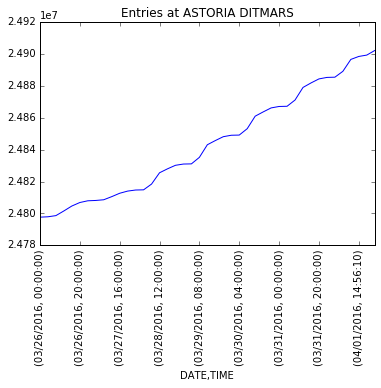

In [12]:
station_hourly_sums.loc[station_of_interest].ENTRIES.plot(
    title='Entries at %s' % station_of_interest,
    rot=90);

# Challenge 8

In [13]:
def append_df_list(dfs, ignore_index=False):
    final_df = dfs[0]
    for df in dfs[1:]:
        final_df = final_df.append(df, ignore_index)
    return final_df

def get_weekly_station_counts(station_name, csv_files):
    csv_files.sort()
    df_list = []
    
    for week_no, f in enumerate(csv_files):
        data = pd.read_csv(f)
                    
        weekly_sums = data[data.STATION == station_of_interest].groupby(['DATE']).sum().reset_index()
        weekly_sums['WEEK_NO'] = week_no

        df_list.append(weekly_sums)
            
    return append_df_list(df_list, ignore_index=False)

# re-used
csv_files_list = ['turnstile_160402.txt', 'turnstile_160326.txt', 'turnstile_160319.txt', 'turnstile_160312.txt']

challenge8 = get_weekly_station_counts(station_of_interest, csv_files_list)

print 'unique WEEK_NO\'s:', challenge8.WEEK_NO.unique()
challenge8.head()

unique WEEK_NO's: [0 1 2 3]


,DATE,ENTRIES,EXITS,WEEK_NO
0,03/05/2016,146833170,147648987,0
1,03/06/2016,146894546,147706500,0
2,03/07/2016,146981640,147768071,0
3,03/08/2016,147090630,147864191,0
4,03/09/2016,147200829,147963549,0


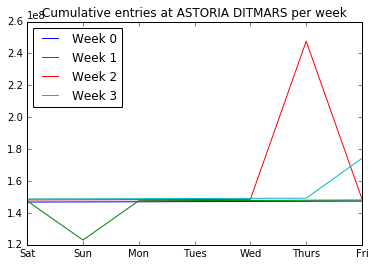

In [14]:
# should be sorted anyway but just in case 
challenge8.sort_values('DATE', inplace=True)

for week_no, grp in challenge8.groupby('WEEK_NO'):
    plt.plot(grp.ENTRIES, label="Week %i" % week_no)

plt.legend(loc='best')
plt.title("Cumulative entries at %s per week" % station_of_interest)
plt.xticks(range(7), 'Sat Sun Mon Tues Wed Thurs Fri'.split())
plt.show()

# Challenge 9

In [15]:
def get_total_station_counts(csv_files):
    csv_files.sort()
    df_list = []
    
    for f in csv_files:
        data = pd.read_csv(f)

        df_list.append(data)
        
    all_data = append_df_list(df_list, ignore_index=True)
            
    return all_data.groupby('STATION', as_index=False, sort=False).sum().sort_values('ENTRIES', ascending=False)

challenge9 = get_total_station_counts(csv_files_list)

print "top 10 stations by summed cumulative entries"
challenge9.head(10)

top 10 stations by summed cumulative entries


,STATION,ENTRIES,EXITS
133,42 ST-PORT AUTH,1322553601815,1068267353878
2,57 ST-7 AV,1267271048779,1099526592668
7,23 ST,1099858195277,1024560056494
4,TIMES SQ-42 ST,985661617668,775954745714
275,GRD CNTRL-42 ST,852086670972,355573642621
134,34 ST-PENN STA,753265754200,356841385306
19,FULTON ST,672846150675,712959804195
125,125 ST,666376455375,328458906991
11,CANAL ST,661723937658,372786550548
106,104 ST,648510724427,534008082421


# Challenge 10

In [16]:
top_10_stations = challenge9.iloc[:10].reset_index().drop('index', axis=1).set_index('STATION')
top_10_stations

,ENTRIES,EXITS
STATION,,
42 ST-PORT AUTH,1322553601815,1068267353878
57 ST-7 AV,1267271048779,1099526592668
23 ST,1099858195277,1024560056494
TIMES SQ-42 ST,985661617668,775954745714
GRD CNTRL-42 ST,852086670972,355573642621
34 ST-PENN STA,753265754200,356841385306
FULTON ST,672846150675,712959804195
125 ST,666376455375,328458906991
CANAL ST,661723937658,372786550548


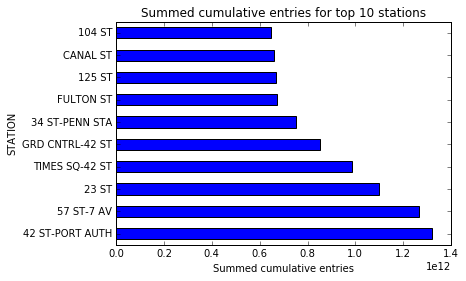

In [17]:
top_10_stations.ENTRIES.plot.barh(
    title="Summed cumulative entries for top 10 stations")
plt.xlabel("Summed cumulative entries");

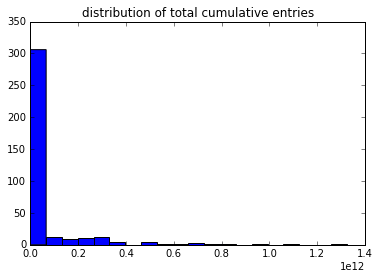

In [18]:
plt.hist(challenge9.ENTRIES, bins=20)
plt.title("distribution of total cumulative entries");